In [6]:
import os
from os.path import join as oj
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from data_load_preprocess import data


import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from copy import deepcopy
import pickle as pkl
import pandas as pd

from params import p
from fit import fit
# from fit_mse import fit_mse

# from fit_ce import fit_ce


plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## fit

In [8]:
results = fit(p)

  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/linux/anaconda3/lib/python3.5/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 20000/20000 [00:23<00:00, 858.10it/s]


# analyze results

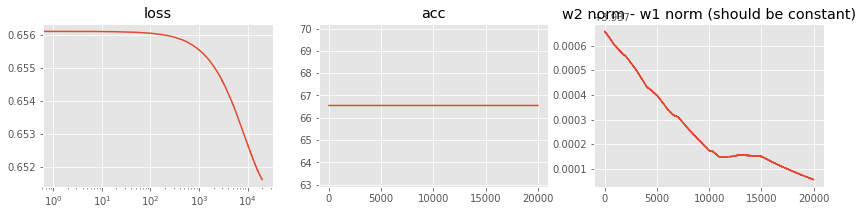

In [4]:
# plot loss and norms
plt.figure(figsize=(14, 3))
plt.subplot(131)
plt.semilogx(results['losses'])
plt.title('loss')

plt.subplot(132)
plt.plot(results['accs'])
plt.title('acc')

plt.subplot(133)
plt.plot(results['norms'][:, 0] - results['norms'][:, 1])
plt.title('w2 norm - w1 norm (should be constant)')
plt.show()

# plotting preds

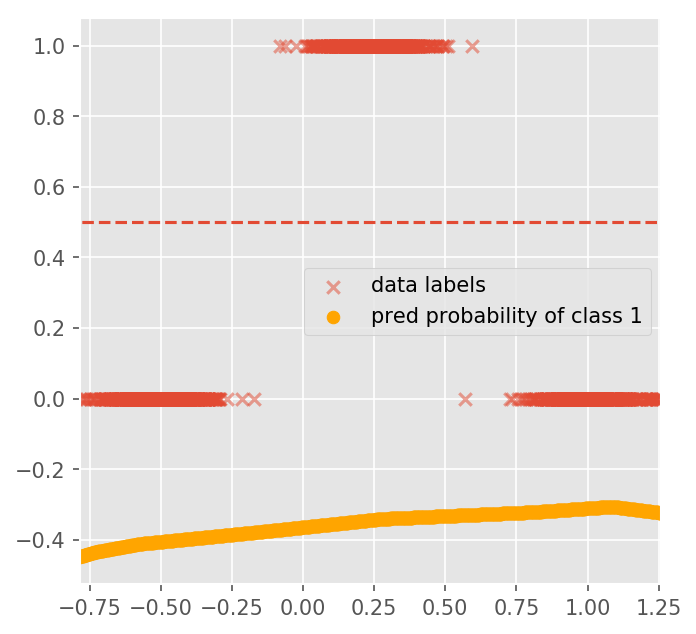

In [5]:
model = results['model']
X, y, y_plot = data.generate_gaussian_data(results['N'], means=results['means'], sds=results['sds'], labs=results['labs'])

# plot predictions
plt.figure(figsize=(5, 5), dpi=150)

preds = model(Variable(torch.from_numpy(X), requires_grad=True)).data.numpy() # predict
# plt.scatter(X, np.argmax(preds, axis=1), label='pred top class')
X_grid = np.linspace(np.min(X), np.max(X), 1000, dtype=np.float32)
X_grid = X_grid.reshape(X_grid.shape[0], 1)
preds_grid = model(Variable(torch.from_numpy(X_grid), requires_grad=True)).data.numpy() # predict

plt.scatter(X, y_plot, label='data labels', alpha=0.5, marker='x')
plt.scatter(X_grid, preds_grid[:, 1], label='pred probability of class 1', color='orange') # note other class is 1 - this
# plt.scatter(X_grid, preds_grid[:, 0], label='pred probability of class 0', color='green') # note other class is 1 - this
plt.plot([-1000, 1000], [0.5, 0.5], '--')
plt.xlim([np.min(X), np.max(X)])
plt.legend()
plt.show()